In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.8.0


In [2]:
class_names = ['normal', 'viral', 'covid','Opacity']

In [3]:
class Radigraphy(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid','Opacity']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
train_dirs = {
    'normal': 'Normal-train',
    'viral': 'Viral-train',
    'covid': 'Covid-train',
    'Opacity':'Opacity-train'
}

train_dataset = Radigraphy(train_dirs, train_transform)

Found 800 normal examples
Found 800 viral examples
Found 800 covid examples
Found 800 Opacity examples


In [6]:
test_dirs = {
    'normal': 'Normal-test',
    'viral': 'Viral-test',
    'covid': 'Covid-test',
    'Opacity':'Opacity-test'
}

test_dataset = Radigraphy(test_dirs, test_transform)

Found 200 normal examples
Found 200 viral examples
Found 200 covid examples
Found 200 Opacity examples


In [7]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 534
Number of test batches 134


In [8]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

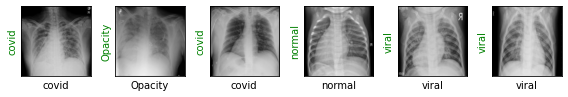

In [9]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

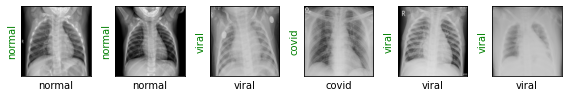

In [10]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [11]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [13]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

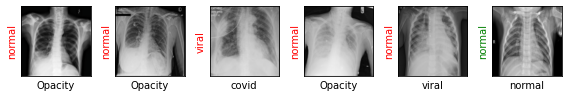

In [14]:
show_preds()

In [15]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()
             

                resnet18.train()

                if accuracy >= 0.90:
                    print('Training was succesful, STOP')
                    return

        train_loss /= (train_step + 1)
        

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/2
Evaluating at step 0
Validation Loss: 1.7257, Accuracy: 0.2562


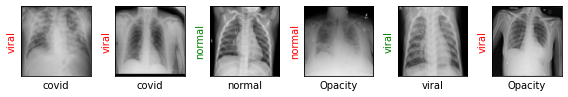

Evaluating at step 20
Validation Loss: 1.0504, Accuracy: 0.4863


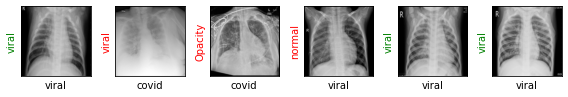

Evaluating at step 40
Validation Loss: 0.7451, Accuracy: 0.7288


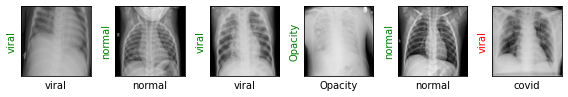

Evaluating at step 60
Validation Loss: 0.5650, Accuracy: 0.7887


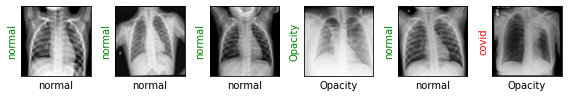

Evaluating at step 80
Validation Loss: 0.4686, Accuracy: 0.8225


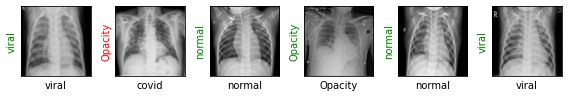

Evaluating at step 100
Validation Loss: 0.3944, Accuracy: 0.8313


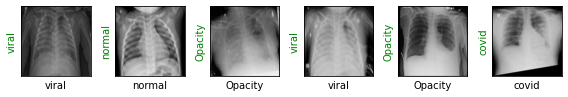

Evaluating at step 120
Validation Loss: 0.3971, Accuracy: 0.8400


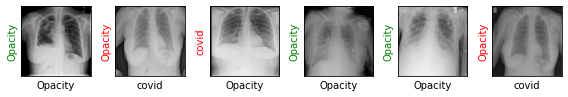

Evaluating at step 140
Validation Loss: 0.4386, Accuracy: 0.8438


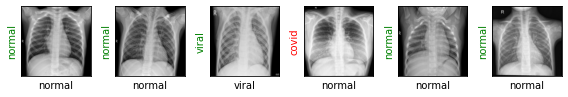

Evaluating at step 160
Validation Loss: 0.3710, Accuracy: 0.8575


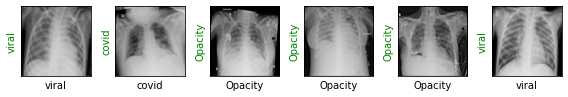

Evaluating at step 180
Validation Loss: 0.3578, Accuracy: 0.8600


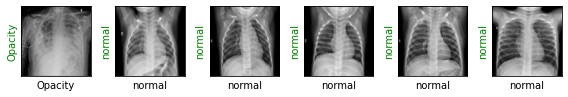

Evaluating at step 200
Validation Loss: 0.3012, Accuracy: 0.8825


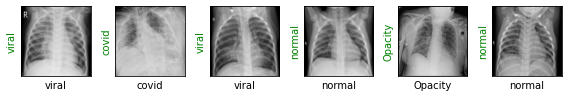

Evaluating at step 220
Validation Loss: 0.2956, Accuracy: 0.8862


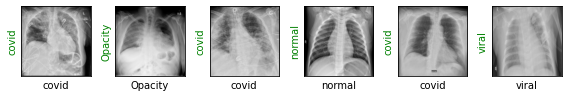

Evaluating at step 240
Validation Loss: 0.2854, Accuracy: 0.8938


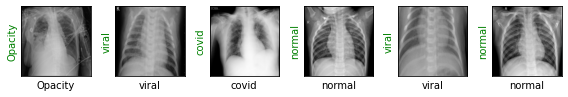

Evaluating at step 260
Validation Loss: 0.3395, Accuracy: 0.8738


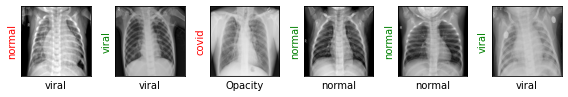

Evaluating at step 280
Validation Loss: 0.2742, Accuracy: 0.8900


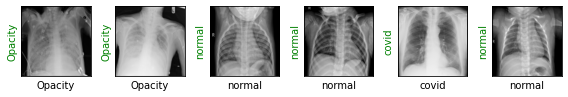

Evaluating at step 300
Validation Loss: 0.2824, Accuracy: 0.8912


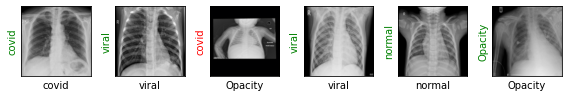

Evaluating at step 320
Validation Loss: 0.2820, Accuracy: 0.8988


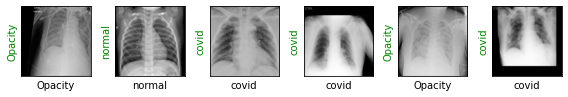

Evaluating at step 340
Validation Loss: 0.2873, Accuracy: 0.9000


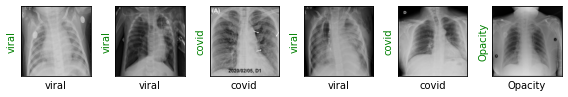

Training was succesful, STOP
Wall time: 12min 10s


In [16]:
%%time

train(epochs=2)

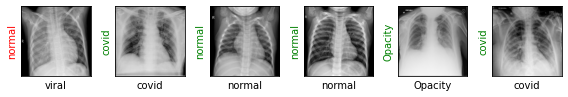

In [17]:
show_preds()